# Laboratorium 3 (Część II) - Podstawowe algorytmy segmentacji

W ramach laboratorium zostanie przedstawione progowanie oraz algorytmy rozrostu obszarów w wersji lokalnej oraz globalnej. Są to najbardziej podstawowe algorytmy segmetnacji pochodzące jeszcze z XX wieku.
Wczytujemy przydatne biblioteki:

In [1]:
import numpy as np
from scipy import ndimage
from skimage import color, io
import time
import matplotlib.pyplot as plt
import skimage.measure as measure
import queue # Do implementacji lokalnej wersji rozrostu obszarów
%matplotlib inline


Do testów przydatne będą dwa obrazy. Jeden syntentyczny, na podstawie którego łatwo można określić poprawność rozwiązania oraz obraz bliższy rzeczywistego.
Na początku wczytajmy i pokażmy jeden z przekrojów CT płuc.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  after removing the cwd from sys.path.


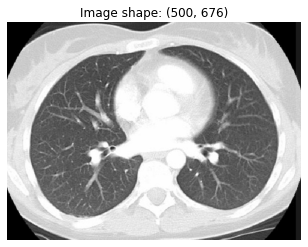

In [2]:
def normalize(image):
    return (image - np.min(image))/(np.max(image) - np.min(image))

image  = normalize(color.rgb2gray(io.imread('CT_lungs.png')))
plt.figure()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image shape: " + str(image.shape))
plt.show()

Następnie wygenerujmy obraz koła i dodajmy do niego losowy szum i znormalizujmy do zakresu \[0, 1\].

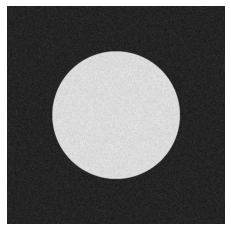

(1024, 1024)


In [3]:
def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

y_size = 1024
x_size = 1024
circle = generate_circle(y_size, x_size, 512, 512, 300)
circle = circle + (np.random.random((y_size, x_size))-0.5)*0.4
circle = normalize(circle)

plt.figure()
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.show()

print(circle.shape)

Najbardziej podstawowym algorytmem segmentacji jest progowanie polegające na uzyskaniu maski binarnej w miejscach wartości, które znajdują się w podanym zakresie.
Napisz funkcję (0.5p): 

In [ ]:
def image_threshold(image, lower, upper):

    return np.logical_and(image > lower, image < upper)

Która jako argumenty przyjmuje obraz, dolną oraz górną wartość progu. Przykładowy wynik działania algorytmu został pokazany poniżej.

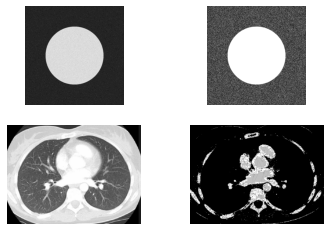

In [ ]:
circle_thresholded = image_threshold(circle, 0.2, 1)
image_thresholded = image_threshold(image, 0.95, 1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_thresholded, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_thresholded, cmap='gray')
plt.axis('off')
plt.show()

Kolejnym algorytmem do implementacji jest algorytm rozrostu obszarów w wersji globalnej (do implementacji, 1p,  podpowiedź: wykorzystaj funkcje label z skimage.measure)

In [ ]:
def region_growing_global(image, seed, bottom_threshold, upper_threshold):
    
    seed_val = image[seed]

    upper = seed_val + upper_threshold
    bottom = seed_val - bottom_threshold

    mask = np.logical_and(image > bottom, image < upper)

    labels = measure.label(mask)
    val_label = labels[seed]

    segmentation_result = np.zeros_like(mask)
    segmentation_result[labels == val_label] = True

    return segmentation_result

Załóżmy, że w obu przypadkach jako punkt startowy chcemy wybrać środek obrazu i że interesują nas wartości maksymalnie o 0.1 różne od punktu początkowego.

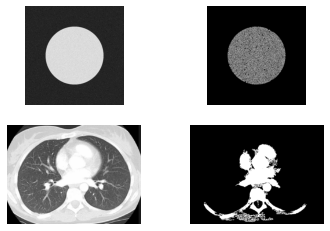

In [ ]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_global = region_growing_global(circle, get_center(circle),  0.1, 0.1)
image_region_global = region_growing_global(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_region_global, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_region_global, cmap='gray')
plt.axis('off')
plt.show()


Ostatnim algorytmem do implementacji jest algorytm rozrostu obszarów w wersji lokalnej (do implementacji, 1p, podpowiedź: poczytaj o algorytmie Dijkstry i odpowiednio go zmodyfikuj, przyda się biblioteka queue oraz set jako struktura danych).

In [ ]:
def region_growing_local(image, seed, bottom_threshold, upper_threshold):
    seed_val = image[seed]

    upper = seed_val + upper_threshold
    bottom = seed_val - bottom_threshold

    pixel_queue = queue.Queue()
    visited = set()

    y_size, x_size = image.shape

    def get_neighbours(coordinate):
        indices = [-1, 0, 1]
        results = list()

        for x in indices:
          for y in indices:
            x_index = max(min(coordinate[1] + x, x_size - 1), 0)
            y_index = max(min(coordinate[0] + y, y_size - 1), 0)
            results.append((y_index, x_index))

        return results

    segmentation_image = np.full(np.shape(image), False)
    pixel_queue.put(seed)

    while not pixel_queue.empty():
        cc = pixel_queue.get()
        cv = image[cc]
        if cv > bottom and cv < upper:
          segmentation_image[cc] = True
        else:
          continue

        neighbours = get_neighbours(cc)
        for i in neighbours:
          if i in visited:
            continue
          else:
            pixel_queue.put(i)
            visited.add(i)

    return segmentation_image

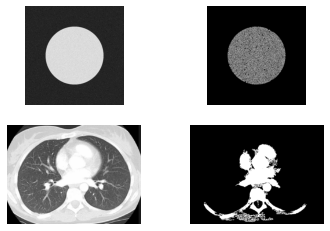

In [ ]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_local = region_growing_local(circle, get_center(circle),  0.1, 0.1)
image_region_local = region_growing_local(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_region_local, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_region_local, cmap='gray')
plt.axis('off')
plt.show()


Porównajmy czas wykonywania obu wersji algorytmu dla różnych wielkości okręgu.

In [ ]:
y_size, x_size = 2048, 2048
values = [16, 32, 64, 128, 256]
times = []
for value in values:
    current_circle = generate_circle(y_size, x_size, 1024, 1024, value)
    b_t = time.time()
    _ = region_growing_local(current_circle, get_center(current_circle), 0.1, 0.1)
    e_t = time.time()
    print("Time for local version, radius: ", value, ": ", e_t - b_t)
    b_t = time.time()
    _ = region_growing_global(current_circle, get_center(current_circle), 0.1, 0.1)
    e_t = time.time()
    print("Time for global version, radius: ", value, ": ", e_t - b_t)
    


Time for local version, radius:  16 :  0.013041019439697266
Time for global version, radius:  16 :  0.032212018966674805
Time for local version, radius:  32 :  0.05269479751586914
Time for global version, radius:  32 :  0.03312063217163086
Time for local version, radius:  64 :  0.20652389526367188
Time for global version, radius:  64 :  0.03180551528930664
Time for local version, radius:  128 :  0.8393793106079102
Time for global version, radius:  128 :  0.035750389099121094
Time for local version, radius:  256 :  3.350233793258667
Time for global version, radius:  256 :  0.03296804428100586


Dlaczego algorytm w wersji lokalnej jest szybszy dla małych obiektów? Dlaczego czas obliczeń dla algorytmu w wersji globalnej nie jest zależny od wielkości obiektu? Który algorytm byłby w obecnych czasach bardziej praktyczny i dlaczego? (0.5p)

Miejce na odpowiedź:

Bardziej zaawansowany algorytm segmentacji, również z XX wieku, zostanie omówiony na Laboratorium 9 - Algorytm aktywnych konturów.
Niemniej jednak, są to algorytmy historyczne stanowiące jedynie wprowadzenie do tematu.
Obecnie w kontekście segmentacji stosowane są już niemal jedynie algorytmy oparte na technikach uczenia głębokiego: https://arxiv.org/pdf/2001.05566.pdf